# Clips vs. inserts at non-predicted IESs

Run this notebook after `Compare_BleTIES_PacBio_Nanopore_predictions.ipynb`

Only about 2/3 of published IESs were recovered by BleTIES.

What is the reason for remainder not to be predicted?

Our hypothesis is that there were insufficient reads sufficiently long to span these IESs, because they were on average longer than those that were successfully reconstructed.

However it is also possible that there was an error in the transfer of IES annotations from the MIC to the MAC assembly coordinates, or that the previous IES predictions were also erroneous.

To verify this, we check for read clips vs. inserts reported by the assembler in the vicinity of the published IES coordinates. If the IESs are indeed present, then the mapper should report clips and (long) inserts. If the IES is present but not predicted, then there should be clips reported, but few or no inserts (insufficient for BleTIES to assemble the IES).

Set cutoff 100 bp for minimum insert length to consider. Count inserts and read clips within +/- 10 bp of the reported IES position.

In [257]:
import pybedtools as pbt
import pysam
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
%%bash
head ref/mic/mic.ies.gff

chr1	default internal_eliminated_sequence		1	36321999	.	.	.	ID=chr1
chr2	default internal_eliminated_sequence		1	25514825	.	.	.	ID=chr2
chr3	default internal_eliminated_sequence		1	31519109	.	.	.	ID=chr3
chr4	default internal_eliminated_sequence		1	31711232	.	.	.	ID=chr4
chr5	default internal_eliminated_sequence		1	27466554	.	.	.	ID=chr5	
chr1	default	internal_eliminated_sequence	29184	32709	.	.	.	ID=IES-04625-r7
chr1	default	internal_eliminated_sequence	62449	66339	.	.	.	ID=IES-04624-r11
chr1	default	internal_eliminated_sequence	100523	102612	.	.	.	ID=IES-05548-r12
chr1	default	internal_eliminated_sequence	110532	115929	.	.	.	ID=IES-05549-r13
chr1	default	internal_eliminated_sequence	122263	126432	.	.	.	ID=IES-05550-r10


In [12]:
%%bash
head ref/mic/ies_relative_to_mac.bed

chr_023	29596	29596	IES-04625-r7
chr_023	3324	3324	IES-04624-r11
chr_001	1449001	1449001	IES-05548-r12
chr_001	1444281	1444281	IES-05549-r13
chr_001	1437950	1437950	IES-05550-r10
chr_001	1431842	1431842	IES-05551-r6
chr_001	1426737	1426737	IES-05552-r11
chr_001	1425136	1425136	IES-05553-r18
chr_001	1417368	1417368	IES-03245-r7
chr_001	1390424	1390424	IES-03244-r16


## Load IES predictions and mapping data

In [18]:
# IES coordinates relative to MAC genome
iesmacbed = pbt.BedTool('ref/mic/ies_relative_to_mac.bed')

In [93]:
# PacBio data

# BleTIES PacBio IES predictions
bleties_pb = pbt.BedTool('tthe_pb_clr.milraa_subreads.comb.milraa_ies.gff3')
# Load alignment MIC->MAC PacBio reads alignment file
map_pb = pysam.AlignmentFile('mapping_pb/pb_subreads.Tthe_MAC_upd.minimap.sort.bam', 'rb')

# Find published IESs with BleTIES predictions within 10 bp
recovered_ies_pb = []
maxdist = 20
#for i in iesmacbed.filter(lambda x: x.chrom == 'chr_023').sort().closest(bleties_pb):
for i in iesmacbed.sort().closest(bleties_pb):
    dist = abs(int(i.fields[7]) - i.start)
    if dist < maxdist:
        recovered_ies_pb.append(i.name)
        #print(" ".join([str(dist), i.fields[0], i.fields[1], i.fields[3], i.fields[7]]))

In [226]:
# Nanopore Data

# BleTIES IES predictions
bleties_ont = pbt.BedTool('tthe_ont.milraa_subreads.comb.milraa_ies.gff3')
# Load alignment MIC->MAC Nanopore reads alignment file
map_ont = pysam.AlignmentFile('mapping_ont/ont.Tthe_MAC_upd.minimap.sort.bam', 'rb')

# Find published IESs with BleTIES predictions within 10 bp
recovered_ies_ont = []
maxdist = 20
for i in iesmacbed.sort().closest(bleties_ont):
    dist = abs(int(i.fields[7]) - i.start)
    if dist < maxdist:
        recovered_ies_ont.append(i.name)

## Count clips and inserts

Reminder: cigartuples are (op, length)

```
M 	BAM_CMATCH 	0
I 	BAM_CINS 	1
D 	BAM_CDEL 	2
N 	BAM_CREF_SKIP 	3
S 	BAM_CSOFT_CLIP 	4
H 	BAM_CHARD_CLIP 	5
P 	BAM_CPAD 	6
= 	BAM_CEQUAL 	7
X 	BAM_CDIFF 	8
B 	BAM_CBACK 	9
```

Reference consuming operations are: 0,2,3,7,8

In [126]:
# PacBio data
# Count clips vs inserts at published IES junctions
REFCONSUMING = [0,2,3,7,8] # Reference consuming BED operations
margin = 10
readcounts_pb = defaultdict(lambda: defaultdict(int))
#for rec in iesmacbed.filter(lambda x: x.chrom == 'chr_023'):
for rec in iesmacbed:
    start = rec.start - margin
    end = rec.start + margin
    allreads = 0
    for read in map_pb.fetch(rec.chrom, start, end):
        # For each read mapping within margin of the IES
        if not read.is_secondary and not read.is_supplementary:
            allreads += 1
            runcount = read.reference_start
            longinsert = 0
            clip = 0
            for cigtup in read.cigartuples:
                if runcount > end:
                    # outside interval end
                    break
                elif runcount > start:
                    # still within interval
                    if cigtup[0] == 4:
                        # if encounter clip, count and break
                        readcounts_pb[rec.name]['clip'] += 1
                        break
                    elif cigtup[0] == 1 and cigtup[1] > 100:
                        # if encounter long insert
                        # count and break
                        readcounts_pb[rec.name]['ins'] += 1
                        break
                if cigtup[0] in REFCONSUMING:
                    runcount += cigtup[1]
    readcounts_pb[rec.name]['tot'] = allreads

In [224]:
# PacBio data
# Convert to a data frame
readcounts_pb_df = pd.DataFrame(readcounts_pb).transpose().fillna(0)
# Add name
readcounts_pb_df['ies'] = readcounts_pb_df.index
# Mark which IESs also recovered by BleTIES
readcounts_pb_df['recovered'] = [i in recovered_ies_pb for i in readcounts_pb_df['ies']]
# Express number of clips or inserts as fraction of total reads mapped to site
readcounts_pb_df['clip_ratio'] = readcounts_pb_df['clip']/readcounts_pb_df['tot']
readcounts_pb_df['ins_ratio'] = readcounts_pb_df['ins']/readcounts_pb_df['tot']
# Export to TSV
readcounts_pb_df.to_csv("pacbio_clipcounts.tsv", sep="\t", index=False)

In [225]:
readcounts_pb_df.head()

,clip,tot,ins,ies,recovered,clip_ratio,ins_ratio
IES-04625-r7,120.0,122.0,0.0,IES-04625-r7,False,0.983607,0.000000
IES-04624-r11,89.0,160.0,68.0,IES-04624-r11,True,0.556250,0.425000
IES-05548-r12,60.0,112.0,48.0,IES-05548-r12,True,0.535714,0.428571
IES-05549-r13,123.0,143.0,20.0,IES-05549-r13,True,0.860140,0.139860
IES-05550-r10,121.0,175.0,50.0,IES-05550-r10,True,0.691429,0.285714


In [227]:
# Nanopore data
# Count clips vs inserts at published IES junctions
REFCONSUMING = [0,2,3,7,8] # Reference consuming BED operations
margin = 10
readcounts_ont = defaultdict(lambda: defaultdict(int))
#for rec in iesmacbed.filter(lambda x: x.chrom == 'chr_023'):
for rec in iesmacbed:
    start = rec.start - margin
    end = rec.start + margin
    allreads = 0
    for read in map_ont.fetch(rec.chrom, start, end):
        # For each read mapping within margin of the IES
        if not read.is_secondary and not read.is_supplementary:
            allreads += 1
            runcount = read.reference_start
            longinsert = 0
            clip = 0
            for cigtup in read.cigartuples:
                if runcount > end:
                    # outside interval end
                    break
                elif runcount > start:
                    # still within interval
                    if cigtup[0] == 4:
                        # if encounter clip, count and break
                        readcounts_ont[rec.name]['clip'] += 1
                        break
                    elif cigtup[0] == 1 and cigtup[1] > 100:
                        # if encounter long insert
                        # count and break
                        readcounts_ont[rec.name]['ins'] += 1
                        break
                if cigtup[0] in REFCONSUMING:
                    runcount += cigtup[1]
    readcounts_ont[rec.name]['tot'] = allreads

In [230]:
# Nanopore data
# Convert to a data frame
readcounts_ont_df = pd.DataFrame(readcounts_ont).transpose().fillna(0)
# Add name
readcounts_ont_df['ies'] = readcounts_ont_df.index
# Mark which IESs also recovered by BleTIES
readcounts_ont_df['recovered'] = [i in recovered_ies_ont for i in readcounts_ont_df['ies']]
# Express number of clips or inserts as fraction of total reads mapped to site
readcounts_ont_df['clip_ratio'] = readcounts_ont_df['clip']/readcounts_ont_df['tot']
readcounts_ont_df['ins_ratio'] = readcounts_ont_df['ins']/readcounts_ont_df['tot']
# Export to TSV
readcounts_ont_df.to_csv("nanopore_clipcounts.tsv", sep="\t", index=False)

## Plot clips vs. inserts for predicted vs. not-predicted IESs

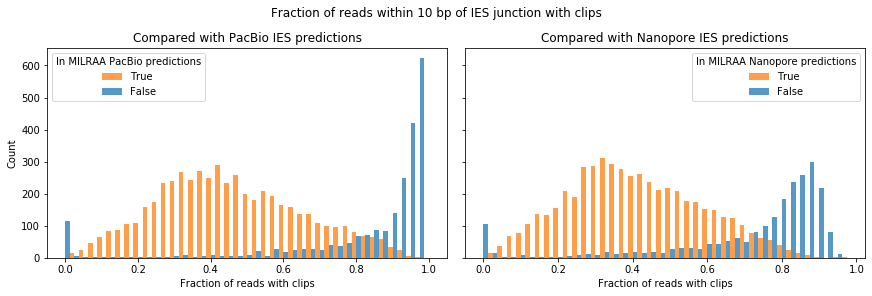

In [269]:
fig, axs = plt.subplots(1,2,figsize=(12,4), constrained_layout=True, sharey=True)
fig.suptitle("Fraction of reads within 10 bp of IES junction with clips")
p1 = sns.histplot(
    data=readcounts_pb_df[['ies','recovered','clip_ratio']],
    x='clip_ratio',hue='recovered',multiple='dodge',
    binwidth=0.025, linewidth=0, ax=axs[0]
)
p1.set_title("Compared with PacBio IES predictions")
p1.set_xlabel("Fraction of reads with clips")
p1.legend(title='In MILRAA PacBio predictions', labels=['True','False'])

p2 = sns.histplot(
    data=readcounts_ont_df[['ies','recovered','clip_ratio']],
    x='clip_ratio',hue='recovered',multiple='dodge',
    binwidth=0.025, linewidth=0, ax=axs[1]
)
p2.set_title("Compared with Nanopore IES predictions")
p2.set_xlabel("Fraction of reads with clips")
p2.legend(title='In MILRAA Nanopore predictions', labels=['True','False'])

fig.savefig("plots/tthe_milraa_vs_published_ies_clip_ratio.png")
fig.savefig("plots/tthe_milraa_vs_published_ies_clip_ratio.pdf")

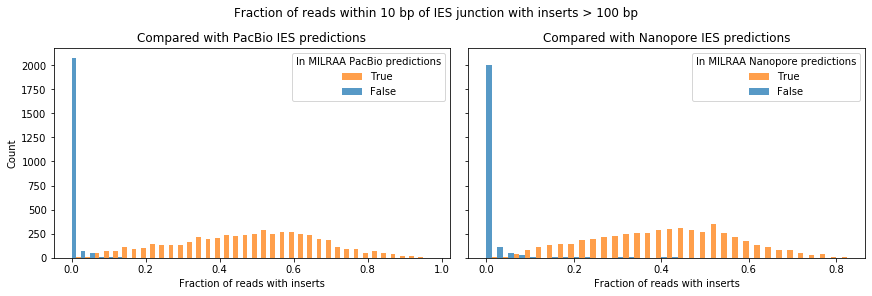

In [270]:
fig, axs = plt.subplots(1,2,figsize=(12,4), constrained_layout=True, sharey=True)
fig.suptitle("Fraction of reads within 10 bp of IES junction with inserts > 100 bp")
p1 = sns.histplot(
    data=readcounts_pb_df[['ies','recovered','ins_ratio']],
    x='ins_ratio',hue='recovered',multiple='dodge',
    binwidth=0.025, linewidth=0, ax=axs[0]
)
p1.set_title("Compared with PacBio IES predictions")
p1.set_xlabel("Fraction of reads with inserts")
p1.legend(title='In MILRAA PacBio predictions', labels=['True','False'])

p2 = sns.histplot(
    data=readcounts_ont_df[['ies','recovered','ins_ratio']],
    x='ins_ratio',hue='recovered',multiple='dodge',
    binwidth=0.025, linewidth=0, ax=axs[1]
)
p2.set_title("Compared with Nanopore IES predictions")
p2.set_xlabel("Fraction of reads with inserts")
p2.legend(title='In MILRAA Nanopore predictions', labels=['True','False'])

fig.savefig("plots/tthe_milraa_vs_published_ies_ins_ratio.png")
fig.savefig("plots/tthe_milraa_vs_published_ies_ins_ratio.pdf")